In [52]:
from typing import Annotated
from langchain_core.tools import tool
from PIL import Image
import json

@tool
def entity_extractor():
    "The function extract entitys from the given document save save them into json format"
    with open('data.json', 'r') as file:
        data = json.load(file)
    return data
@tool
def clasfiy_document(data):
    "The function extract entitys from the given document save save them into json format"
    
    return "i have classifed data and save into data.json"
    
    
@tool
def validate_document():
    """your a information validator export"""
    with open('data.json', 'r') as file:
        data = json.load(file)
    return "invalid if proof as user to upload rigth document"

@tool
def user_input():
    """Ask user to upload proper document"""
    doc=input("Document")
    return "claim pass sucess"

In [82]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["extraction", "extraction"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " Once the infromation is valid please respond and finish"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()
llm=ChatGroq(model_name="Gemma2-9b-It")



class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    print("-----------------------------------------------------")
    print(f"Supervisor received request: {state}")
    print("-----------------------------------------------------")
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [90]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


extraction_agent = create_react_agent(
    llm, tools=[entity_extractor,clasfiy_document], prompt="your expert at extarcting entity and clasifying"
)


def extraction_node(state: State) -> Command[Literal["supervisor"]]:
    result = extraction_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="extraction")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
validate_agent = create_react_agent(llm, tools=[validate_document,user_input])


def validate_node(state: State) -> Command[Literal["supervisor"]]:
    result = validate_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="validator")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("extraction", extraction_node)
builder.add_node("validator", validate_node)
builder.add_edge("extraction", END)
builder.add_edge("validator", END)

graph = builder.compile()

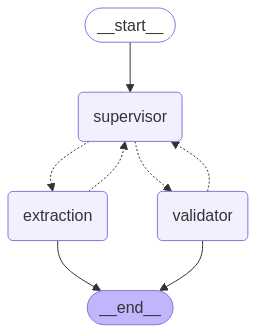

In [91]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [85]:
for s in graph.stream(
    {"messages": [("user", "Just Valdiate   and check if Claim  in pass")]}, subgraphs=True
):
    print(s)
    print("----")

-----------------------------------------------------
Supervisor received request: {'messages': [HumanMessage(content='Just Valdiate   and check if Claim  in pass', additional_kwargs={}, response_metadata={}, id='6910814b-ea7c-43d7-b5d0-acada4cffe77')]}
-----------------------------------------------------
((), {'supervisor': {'next': 'validator'}})
----
(('validator:2154daab-bf06-729d-bdd5-5dd583c5f062',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_z3q9', 'function': {'arguments': '{}', 'name': 'validate_document'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 985, 'total_tokens': 1059, 'completion_time': 0.134545455, 'prompt_time': 0.03461539, 'queue_time': 0.237456725, 'total_time': 0.169160845}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ffef26be-2d7f-437b-9a83-79e0f67fc5b0-0', tool_calls=[{'name

Document dfg


(('validator:2154daab-bf06-729d-bdd5-5dd583c5f062',), {'tools': {'messages': [ToolMessage(content='claim pass sucess', name='user_input', id='5fa7402f-1648-47ab-ad22-83bd79310905', tool_call_id='call_8yxq')]}})
----
(('validator:2154daab-bf06-729d-bdd5-5dd583c5f062',), {'agent': {'messages': [AIMessage(content='Just Valdiate   and check if Claim  in pass \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 1127, 'total_tokens': 1143, 'completion_time': 0.029090909, 'prompt_time': 0.039659581, 'queue_time': 0.23447962700000002, 'total_time': 0.06875049}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d5c2a238-bd39-41c3-8608-825a6f28e31e-0', usage_metadata={'input_tokens': 1127, 'output_tokens': 16, 'total_tokens': 1143})]}})
----
((), {'validator': {'messages': [HumanMessage(content='Just Valdiate   and check if Claim  in pass \n', additional_kwargs={}, response_m

In [11]:
a=[45,5,63,35,65]
l=[i for i in a if (i%5)==0]

In [12]:
l

[45, 5, 35, 65]

In [16]:
isinstance(22,int)

True